## Import python packages

In [1356]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

## Import data

In [1357]:
data_dir = "/Users/alberteenglund/Documents/DTU/8_Semester/22125_algorithms_in_bioinformatics/algorithms/BioAlgoProject2025/data/"

### Define runtime parameters

In [1358]:
# Define if we are using blosum or sparse encoding
blosum_scheme = False
#blosum_scheme = True

### Alphabet

In [1359]:
alphabet_file = data_dir + "Matrices/alphabet"
#alphabet_file = "https://raw.githubusercontent.com/brunoalvarez89/data/master/algorithms_in_bioinformatics/part_3/alphabet"
alphabet = np.loadtxt(alphabet_file, dtype=str)

### Blosu50 encoding scheme

In [1360]:
blosum_file = data_dir + "Matrices/blosum50"
#blosum_file = "https://raw.githubusercontent.com/brunoalvarez89/data/master/algorithms_in_bioinformatics/part_3/blosum50"

_blosum50 = np.loadtxt(blosum_file, dtype=float).reshape((24, -1)).T

blosum50 = {}

for i, letter_1 in enumerate(alphabet):
    
    blosum50[letter_1] = {}

    for j, letter_2 in enumerate(alphabet):
        
        blosum50[letter_1][letter_2] = _blosum50[i, j] / 5.0

### Sparce encoding scheme

In [1361]:
sparse_file = data_dir + "Matrices/sparse"

_sparse = np.loadtxt(sparse_file, dtype=float)
sparse = {}

for i, letter_1 in enumerate(alphabet):

    sparse[letter_1] = {}

    for j, letter_2 in enumerate(alphabet):

        sparse[letter_1][letter_2] = _sparse[i, j]

## Peptide encoding

In [1362]:
def encode(peptides, encoding_scheme, alphabet):
    """
    Encode a list of peptides using the specified encoding scheme.

        Parameters:
            peptides (list): List of peptide sequences to encode.
            encoding_scheme (dict): Dictionary containing the encoding scheme.
            alphabet (list): List of letters in the alphabet used for encoding.

        Returns:
            np.ndarray: A 2D numpy array where each row corresponds to an encoded peptide.
    """
    
    encoded_peptides = []

    for peptide in peptides:

        encoded_peptide = []

        for peptide_letter in peptide:

            for alphabet_letter in alphabet:

                encoded_peptide.append(encoding_scheme[peptide_letter][alphabet_letter])
        
        # add a 1 (bias)
        encoded_peptide.append(1)
        
        # store peptide
        encoded_peptides.append(encoded_peptide)
        
    return np.array(encoded_peptides)


## Neural network functions

### Activation (sigmoid)

In [1363]:
def sigmoid(z):
    """
    Compute the sigmoid function for a given input.

        Parameters:
            z (float or np.ndarray): Input value(s) for which to compute the sigmoid.

        Returns:
            float or np.ndarray: The computed sigmoid value(s).
    """    
    
    return 1.0 / (1.0 + np.exp(-z))

### Forward Propagation

In [1364]:
def forward(X, w1, w2):
    
    # X contains the output from each layer, i.e the input values in the first layer
    # w1 are weights connecting input to hidden, and w2 weights connecting hidden to output
    # In w[i,j]; i is from and j is to
   
    # get dimension, substracting the bias
    input_layer_dim = w1.shape[0] - 1 
    hidden_layer_dim = w2.shape[0] - 1
    
    ################
    # hidden layer #
    ################
    
    # activity of hidden layer
    # Remember z_j = sum_i w(i,j)*input(i)
    for j in range(hidden_layer_dim):
        z = 0.0
        for i in range(input_layer_dim+1):
            # z += XXX
            z += X[0][i] * w1[i, j] # This is the first layer, so we use X[0]. w1 connects input to hidden, so we use w1[i][j] because we have j neurons in the hidden layer.
        # X[1][j] = XXX
        X[1][j] = sigmoid(z) # This is the second layer, so we use X[1]
    
    ################
    # output layer #
    ################
    
    z = 0
    for i in range(hidden_layer_dim+1):
        # z += XXX
        z += X[1][i] * w2[i, 0] # This is the second layer, so we use X[1]. w2 connects hidden to output, so we use w2[i][0] because we have only one output neuron.
    # X[2][0] = XXX
    X[2][0] = sigmoid(z) # This is the third layer, so we use X[2]
    

## Prediction data

In [1365]:
evaluation_file = data_dir + "all_files_new/B5701/e000.csv"     # Should be changed!!!

evaluation_data = np.loadtxt(evaluation_file, dtype=str)

peptides = evaluation_data[:, 0]
if blosum_scheme:
    x_eval = encode(peptides, blosum50, alphabet)
else:
    x_eval = encode(peptides, sparse, alphabet)

y_eval = np.array(evaluation_data[:, 1], dtype=float)

## Function to load previously saved Network

In [1366]:
def load_network(file_name):
    """
    Load the weights of a neural network from a file.
        
        Parameters:
            file_name (str): The name of the file containing the network weights.
        
        Returns:
            tuple: A tuple containing two numpy arrays:
                - w_h_load: Weights from input layer to hidden layer.
                - w_o_load: Weights from hidden layer to output layer.
    """

    f = open(file_name, "r")

    n_line = 0

    weight_list = []

    for line in f:


        # clean and separate line
        sline = line.strip().split()


        # input layer dimension
        if n_line == 1:
            input_layer_dim = int(sline[0])

        # hidden layer dimension    
        if n_line == 2:
            hidden_layer_dim = int(sline[0])

        # output layer dimension
        if n_line == 3:
            output_layer_dim = int(sline[0])

        # model weights
        if n_line >= 5:
            for i in range(0, len(sline)):
                weight_list.append(float(sline[i]))

        n_line += 1

    # HIDDEN LAYER WEIGHTS
    # w_h[i, j] is the weight that links input's feature "i" to neuron "j" of the hidden layer        
    w_h_load = np.zeros(shape=(input_layer_dim+1, hidden_layer_dim))

    for i in range(0, (input_layer_dim+1)*hidden_layer_dim, hidden_layer_dim):

        for j in range(0, hidden_layer_dim):

            row = i // hidden_layer_dim

            w_h_load[row, j] = weight_list[i+j]

            
    # OUTPUT LAYER WEIGHTS
    # w_o[i, j] is the weight that links hidden layer's neuron "i" to neuron "j" of the output layer
    w_o_load = np.zeros(shape=(hidden_layer_dim+1, output_layer_dim))

    w_h_end = (input_layer_dim+1) * hidden_layer_dim

    for i in range(w_h_end, w_h_end+hidden_layer_dim+1, output_layer_dim):

        for j in range(0, output_layer_dim):

            row = (i - w_h_end) // output_layer_dim
            w_o_load[row, j] = weight_list[i+j]
            
            
    # return weight matrices
    return w_h_load, w_o_load

## Main code

In [1367]:
# Load network
synfile_name = "/Users/alberteenglund/Documents/DTU/8_Semester/22125_algorithms_in_bioinformatics/algorithms/BioAlgoProject2025/results/ANN/B5701.res/blosum/hidden.5/epi.0.1/B5701-blosum-5-0.1-4.syn"
# synfile_name = data_dir + "ANN/A2403_bl.syn"
# synfile_name = data_dir + "ANN/A0201_sp.syn"
# synfile_name = data_dir + "ANN/A0201_bl.syn"
w_h, w_o = load_network(synfile_name)

In [1368]:
# X matrix 
input_layer_dim = w_h.shape[0]
hidden_layer_dim = w_o.shape[0]
output_layer_dim = w_o.shape[1]

In [1369]:
# Find max network dimensions
X_dim = max(input_layer_dim, hidden_layer_dim, output_layer_dim)
X = np.zeros(shape=(3, X_dim))

In [1370]:
# The last column in each X layer is set to 1 to deal with the bias weights
X[0][input_layer_dim-1] = 1.0 
X[1][hidden_layer_dim-1] = 1.0

In [1371]:
# data for plotting
y_preds_eval = []

# loop
for i in range(0, len(x_eval)):        

    # fetch training point
    x = x_eval[i]
    y = y_eval[i]

    if len(x) == input_layer_dim:
        
        X[0] = x

        # forward propagation
        forward(X, w_h, w_o)
        # y_pred = XXX
        y_pred = X[2][0] # This is the third layer, so we use X[2][0] to get the output prediction
        
        y_preds_eval.append(y_pred)
        
        print(peptides[i], y_pred, y)
    else:
        print("Error. Peptide length", len(x),"does not match network sizs", input_layer_dim, "Skip")

# store training performance
eval_perf = pearsonr(y_eval, np.asarray(y_preds_eval))[0]

YCAVVPLVY 0.1953393204688607 0.16655
YSAVVPLVY 0.20747792013527655 0.401274
YPAVVPLVY 0.18909673302152882 0.025892
YTAVVPLVL 0.20227391194279146 0.159186
YVIPHVHAF 0.23950469307392264 0.365031
YKAVVPLVY 0.17767602667082483 0.104619
YTDVVPLVY 0.2499617135537713 0.098206
YNAVVPLVY 0.1869593617812419 0.083856
KAGQYVTIW 0.31269726691770766 0.713395
YTAVVPLVC 0.19178228728351618 0.073287
YTAVVPLVW 0.2511384951915416 0.583267
YYAVVPLVY 0.16971729068817915 0.102116


# Prediction PCC: 0.8185


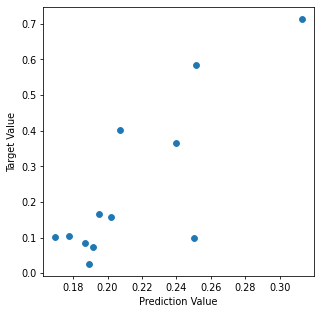

In [1372]:
# PERFORMANCE REPORT
fig = plt.figure(figsize=(5, 5), dpi = 70)

plt.scatter(y_preds_eval, y_eval)
plt.ylabel("Target Value", fontsize=10);
plt.xlabel("Prediction Value", fontsize=10);

# print performance
print("# Prediction PCC:", round(eval_perf, 4))

    peptide_length  target  prediction
0                9       0    0.248661
1                9       0    0.288105
2                9       0    0.238442
3                9       0    0.204422
4                9       0    0.304235
5                9       0    0.196853
6                9       0    0.302195
7                9       0    0.243099
8                9       1    0.589893
9                9       0    0.132208
10               9       1    0.443388
11               9       0    0.126793
12               9       0    0.211684
13               9       0    0.242475
14               9       0    0.192609
15               9       0    0.180083
16               9       0    0.355521
17               9       0    0.171805
18               9       0    0.248361
19               9       0    0.208580
20               9       1    0.497357
21               9       0    0.119298
22               9       1    0.395570
23               9       0    0.129161
24               9       

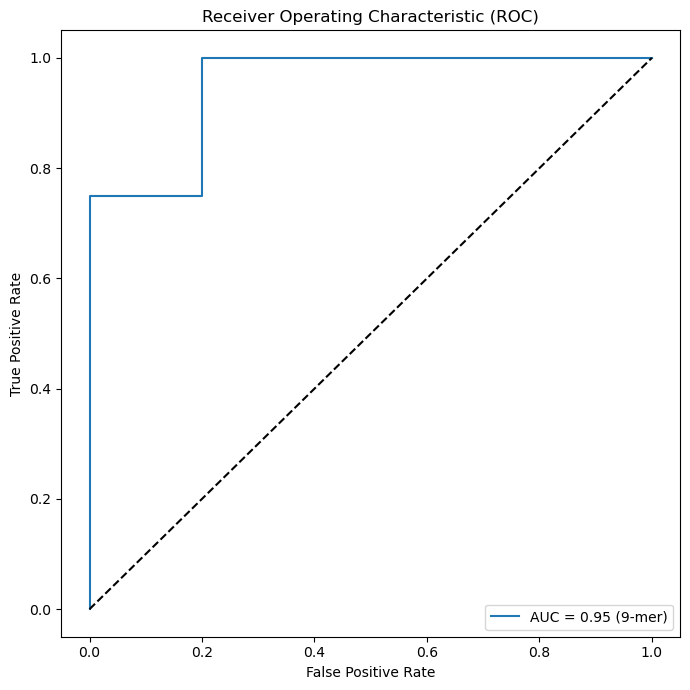

In [1382]:
# %% [markdown]
# ## ROC-AUC Plotting

# %%
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

pred_file = "/Users/alberteenglund/Documents/DTU/8_Semester/22125_algorithms_in_bioinformatics/algorithms/BioAlgoProject2025/results/ANN/B5701.res/blosum/hidden.5/epi.0.1/concat.eval"
pred_data = np.loadtxt(pred_file, dtype=str)

y_eval_new = np.array(pred_data[:, 2], dtype=float)
y_preds_eval_new = np.array(pred_data[:, 1], dtype=float)

# Set threshold for binary classification
BINDER_THRESHOLD = 0.426

# Convert predictions and true values into binary classes

y_eval_class = np.where(y_eval_new.flatten() >= BINDER_THRESHOLD, 1, 0)
y_preds_class = np.where(np.array(y_preds_eval_new).flatten() >= BINDER_THRESHOLD, 1, 0)

# print(y_eval_class)
# print(y_preds_class)

# Combine into dataframe for peptide length-specific ROC curves
# Ensure peptides are correctly defined
peptide_lengths = np.array([len(p) for p in pred_data[:, 0]])  # Use the first column of pred_data for peptide sequences
pred_per_len = pd.DataFrame({
    'peptide_length': peptide_lengths,
    'target': y_eval_class,
    'prediction': np.array(y_preds_eval_new)
})
print(pred_per_len)

# Function to plot ROC curve for a specific peptide length
def plot_roc_curve(fpr, tpr, roc_auc, length):
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f} ({length}-mer)')

# Plot ROC curve for each peptide length
plt.figure(figsize=(7, 7))
for length, group in pred_per_len.groupby('peptide_length'):
    fpr, tpr, _ = roc_curve(group['target'], group['prediction'])
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr, roc_auc, length)

# Plot formatting
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("roc_auc_plot.png")
plt.show()

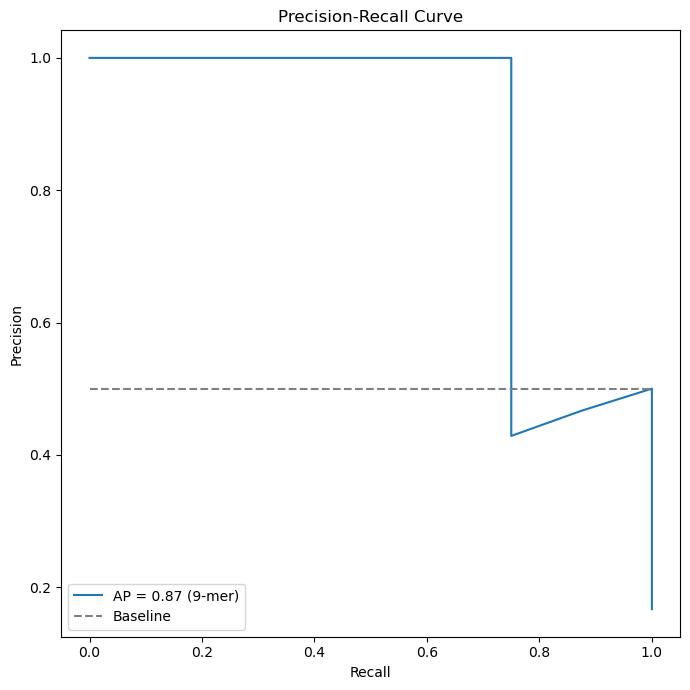

In [1383]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Function to plot PR curve for a specific peptide length
def plot_pr_curve(precision, recall, ap, length):
    plt.plot(recall, precision, label=f'AP = {ap:.2f} ({length}-mer)')

# Plot PR curve for each peptide length
plt.figure(figsize=(7, 7))
for length, group in pred_per_len.groupby('peptide_length'):
    precision, recall, _ = precision_recall_curve(group['target'], group['prediction'])
    ap = average_precision_score(group['target'], group['prediction'])
    plot_pr_curve(precision, recall, ap, length)

# Plot formatting
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot([0, 1], [0.5, 0.5], linestyle='--', color='gray', label="Baseline")
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig("pr_curve.png")
plt.show()
